<a href="https://colab.research.google.com/github/ShivaniGawande/DLFinalProject_Fall22/blob/main/ReadingBetweenLines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [10]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np 
import pandas as pd
import seaborn as sns
import gensim
import re, string, unicodedata
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading Dataset

In [49]:
#loading data from google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#train_file_id = '15NNft0C1CKlKDzjUKbAgibbXTFe8NFgG'
test_file_id = '1J4K-z82tEr4jkwG1Hl1t-eigpcivqt3k' 
'''
download = drive.CreateFile({'id': train_file_id})
download.GetContentFile('train.csv')
train_data  = pd.read_csv("train.csv")
train_data.head()
'''
url = "https://raw.githubusercontent.com/EducationalTestingService/sarcasm/master/twitter/sarcasm_detection_shared_task_twitter_training.jsonl"
df = pd.read_json(url, lines=True)
print(df.head())
     

     label                                           response  \
0  SARCASM  @USER @USER @USER I don't get this .. obviousl...   
1  SARCASM  @USER @USER trying to protest about . Talking ...   
2  SARCASM  @USER @USER @USER He makes an insane about of ...   
3  SARCASM  @USER @USER Meanwhile Trump won't even release...   
4  SARCASM  @USER @USER Pretty Sure the Anti-Lincoln Crowd...   

                                             context  
0  [A minor child deserves privacy and should be ...  
1  [@USER @USER Why is he a loser ? He's just a P...  
2  [Donald J . Trump is guilty as charged . The e...  
3  [Jamie Raskin tanked Doug Collins . Collins lo...  
4  [Man ... y ’ all gone “ both sides ” the apoca...  


In [12]:
'''download = drive.CreateFile({'id': test_file_id})
download.GetContentFile('test.csv')
test_data  = pd.read_csv("test.csv")
test_data.head()
'''

'download = drive.CreateFile({\'id\': test_file_id})\ndownload.GetContentFile(\'test.csv\')\ntest_data  = pd.read_csv("test.csv")\ntest_data.head()\n'

#Model Implementation

Baseline model - word2vec

In [13]:
df.isna().sum() # Checking for NaN values

label       0
response    0
context     0
dtype: int64

In [14]:
df.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


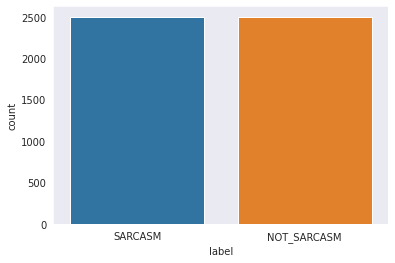

In [15]:
sns.set_style("dark")
sns.countplot(df.label)

Our dataset is balanced.

In [16]:
stop = set(stopwords.words('english'))

def remove_masked_user(text):
    return text.replace('@USER', '')

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

'''
def remove_url(text):
  return text.replace('<url>', '')

'''

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    text = remove_masked_user(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [ ]:
#df['response']=df['response'].apply(denoise_text)
#print ('<url>' in df['response'] )

In [17]:
words = []
for i in df.response.values:
    words.append(i.split())
#words[-1] = words[-1].append('<url>')
words[:3]


[['@USER',
  '@USER',
  '@USER',
  'I',
  "don't",
  'get',
  'this',
  '..',
  'obviously',
  'you',
  'do',
  'care',
  'or',
  'you',
  "would've",
  'moved',
  'right',
  'along',
  '..',
  'instead',
  'you',
  'decided',
  'to',
  'care',
  'and',
  'troll',
  'her',
  '..'],
 ['@USER',
  '@USER',
  'trying',
  'to',
  'protest',
  'about',
  '.',
  'Talking',
  'about',
  'him',
  'and',
  'his',
  'labels',
  'and',
  'they',
  'label',
  'themselves',
  'WTF',
  'does',
  'that',
  'make',
  'em',
  '?'],
 ['@USER',
  '@USER',
  '@USER',
  'He',
  'makes',
  'an',
  'insane',
  'about',
  'of',
  'money',
  'from',
  'the',
  'MOVIES',
  ',',
  'Einstein',
  '!',
  '#LearnHowTheSystemWorks']]

In [20]:
print('<url>' in words)

False


In [21]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 200
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [23]:
#vocab size
len(w2v_model.wv.vocab)

16706

In [ ]:
#url_token = w2v_model.wv['<url>']

In [27]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = pad_sequences(tokenized_train, maxlen = 20)
vocab_size = len(tokenizer.word_index) + 1

In [28]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        if '@user' or '<url>' == word: continue
        weight_matrix[i] = model[word]
    return weight_matrix

In [35]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [36]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 200)           2863200   
                                                                 
 bidirectional_6 (Bidirectio  (None, 20, 256)          336896    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,255,841
Trainable params: 3,255,841
Non-trainable params: 0
_________________________________________________________________


In [50]:
label_mapping = {'SARCASM': 1, 'NOT_SARCASM': 0}
df['label'] = df['label'].map(label_mapping)

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x, df.label , test_size = 0.3 , random_state = 0) 

In [51]:
df.label

0       1
1       1
2       1
3       1
4       1
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: label, Length: 5000, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


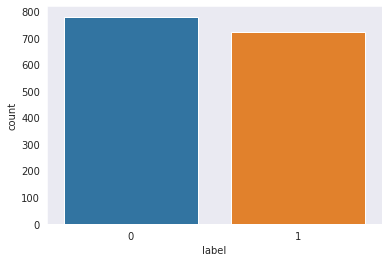

In [53]:
sns.set_style("dark")
sns.countplot(y_test)

In [54]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 15)

Epoch 1/15
28/28 [==============================] - 39s 856ms/step - loss: 0.6067 - acc: 0.6797 - val_loss: 0.5230 - val_acc: 0.7367
Epoch 2/15
28/28 [==============================] - 16s 569ms/step - loss: 0.1996 - acc: 0.9266 - val_loss: 0.8140 - val_acc: 0.6973
Epoch 3/15
28/28 [==============================] - 16s 575ms/step - loss: 0.0744 - acc: 0.9760 - val_loss: 0.7940 - val_acc: 0.7360
Epoch 4/15
28/28 [==============================] - 16s 580ms/step - loss: 0.0248 - acc: 0.9920 - val_loss: 1.2021 - val_acc: 0.7233
Epoch 5/15
28/28 [==============================] - 16s 568ms/step - loss: 0.0095 - acc: 0.9963 - val_loss: 1.2517 - val_acc: 0.7200
Epoch 6/15
28/28 [==============================] - 16s 563ms/step - loss: 0.0089 - acc: 0.9977 - val_loss: 1.5886 - val_acc: 0.7127
Epoch 7/15
28/28 [==============================] - 17s 602ms/step - loss: 0.0062 - acc: 0.9977 - val_loss: 1.7476 - val_acc: 0.7173
Epoch 8/15
28/28 [==============================] - 16s 568ms/step - 

In [56]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

110/110 [==============================] - 12s 99ms/step - loss: 0.0394 - acc: 0.9909
Accuracy of the model on Training Data is -  99.08571243286133
47/47 [==============================] - 6s 125ms/step - loss: 1.4064 - acc: 0.7033
Accuracy of the model on Testing Data is -  70.333331823349


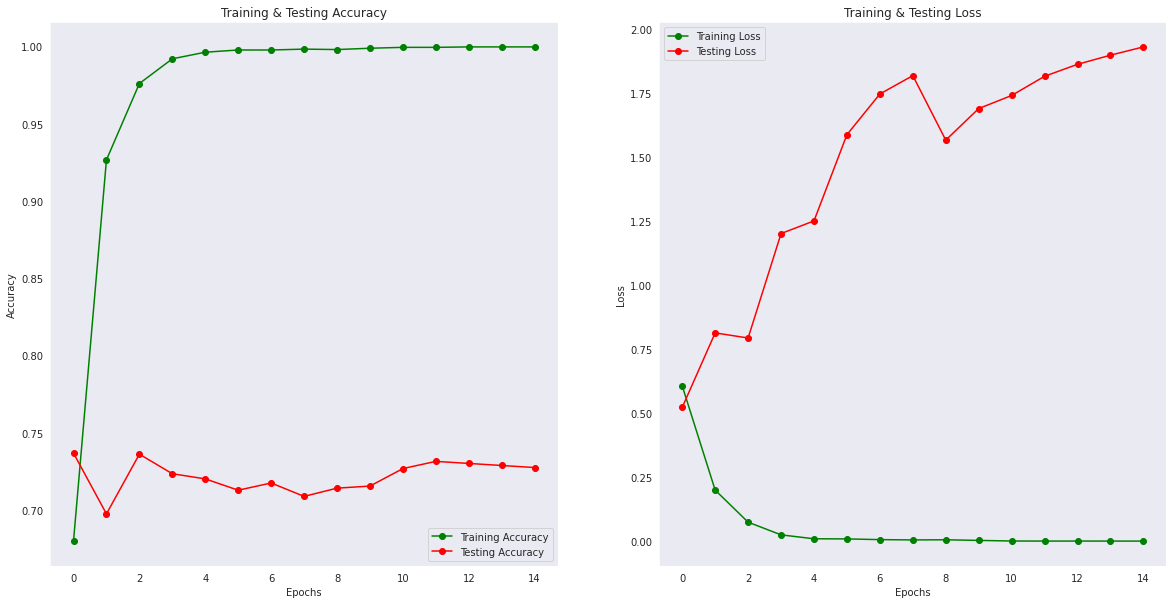

In [57]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [60]:
y_proba = model.predict_on_batch(x_test)
y_pred = y_proba.argmax(axis=-1)

In [61]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[779,   0],
       [721,   0]])

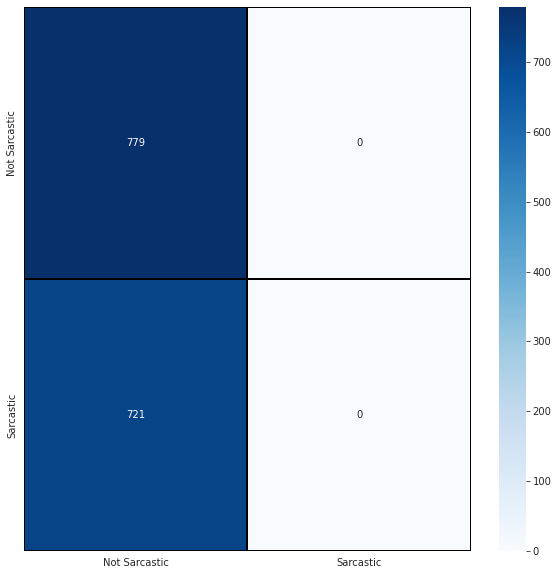

In [62]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])